## Implementing a Review classification model with Catboost and SageMaker

#### Data set: Amazon Customer Reviews Dataset
   
    Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.
 
#### Approach
   1. The Review classficiation is NLP machine learning model to predict whether a review posted by the customer is positive or negative. For the sake of simplification, we have converted the ratings provided by the customer into a binary target variable with value equals to 1 when ratings were either 4 or 5. 

   2. In present work, after spilitting the data into train and test we created a feature engineerng pipeline on training data using natural language processing techiniques. The dataset was futher split into 10 chunks to demonstrate distributed learning, where during training not more than 1204 [batch_size] records are loaded onto memory at a time.
   
   
####  Setup
This notebook was created and tested on an ml.p2.xlarge notebook instance.

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the get_execution_role() call with the appropriate full IAM role arn string(s).

In [2]:
from sagemaker import get_execution_role
from sagemaker.session import Session
import boto3

bucket = '<your_s3_bucket_name_here>'
custom_code_upload_location = 's3://{}/sagemaker/DEMO-GPU-Catboost/customcode'.format(bucket)
model_artifacts_location = 's3://{}/sagemaker/DEMO-GPU-Catboost/artifacts'.format(bucket)

role = get_execution_role()

### Data
##### Explore
Let's start by bringing in our dataset from an S3 public bucket. As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos. More details on this dataset can be found at its AWS Public Datasets page.

Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes. Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage).


Let's read the data into a Pandas DataFrame so that we can begin to understand it.

Note, we'll set error_bad_lines=False when reading the file in as there appear to be a very small number of records which would create a problem otherwise.

In [7]:
import pandas as pd
import csv
fname = 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'
df = pd.read_csv(fname,sep='\t',delimiter='\t',error_bad_lines=False)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'



We can see this dataset includes information like:

   1. marketplace: 2-letter country code (in this case all "US").
   2. customer_id: Random identifier that can be used to aggregate reviews written by a single author.
   3. review_id: A unique ID for the review.
   4. product_id: The Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN> links to the product's detail page.
   5. product_parent: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
   6. product_title: Title description of the product.
   7. product_category: Broad product category that can be used to group reviews (in this case digital videos).
   8. star_rating: The review's rating (1 to 5 stars).
   9. helpful_votes: Number of helpful votes for the review.
   10. total_votes: Number of total votes the review received.
   11. vine: Was the review written as part of the Vine program?
   12. verified_purchase: Was the review from a verified purchase?
   13.  review_headline: The title of the review itself.
   14. review_body: The text of the review.
   15.  review_date: The date the review was written.
    
    
For this example, let's limit ourselves 'verified_purchase','review_headline','review_body','product_title','helpful_votes and star_rating. 


##### Pre-processing
1. Replace any NaN values with empty string
2. Create Target column based the star rating

In [8]:
import numpy as np
def pre_process(df):
    df.fillna(
        value={'review_body': '', 'review_headline': ''}, inplace=True)
    df.fillna(
        value={'verified_purchase': 'Unk'}, inplace=True)

    df.fillna(0, inplace=True)
    return df

df = pre_process(df)

df.review_date = pd.to_datetime(df.review_date)
df['target'] = np.where(df['star_rating']>=4,1,0)

##### Split the data into Train, validation and Test set
Note: We have used stratefied sampling as the criteria for splittng the data; stratefied sampling on the target variable insures same distribution of the varible across all the splits.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.10, random_state=0)

sss.get_n_splits(df, df['target'])
for train_index, test_index in sss.split(df, df['target']):
    X_train_vallid , X_test = df.iloc[train_index], df.iloc[test_index]
    
    
sss.get_n_splits(X_train_vallid, X_train_vallid['target'])    
for train_index, test_index in sss.split(X_train_vallid, X_train_vallid['target']):
    X_train , X_valid = X_train_vallid.iloc[train_index], X_train_vallid.iloc[test_index]
    
    
print(X_train.target.value_counts()[1]/(X_train.target.value_counts().sum()))
print(X_test.target.value_counts()[1]/(X_test.target.value_counts().sum()))
print(X_valid.target.value_counts()[1]/(X_valid.target.value_counts().sum()))

0.7920667165021078
0.7920667275251041
0.7920667165021078


In [11]:
import csv
X_train.to_csv('data/train/file_1', index=False,sep='\t', quotechar='"', quoting=csv.QUOTE_ALL)
X_valid.to_csv('data/valid/file_1', index=False,sep='\t', quotechar='"', quoting=csv.QUOTE_ALL)
X_test[cols].to_csv('data/test/file_1', index=False, header=False, sep='\t',quotechar='"', 
                    escapechar ='\\',quoting=csv.QUOTE_NONE)

In [ ]:
### repalce with your bucket name
! aws s3 cp ./data/ s3://<your bucket name>/sagemaker/DEMO-GPU-Catboost/data/ --recursive --acl bucket-owner-full-control

In [262]:
cols = ['marketplace', 'customer_id', 'review_id', 'product_id','helpful_votes',
        'verified_purchase','review_headline','review_body','product_title','target']
X_test[cols].to_csv('data/test/file_1', index=False, header=False, sep='\t',quotechar='"', 
                    escapechar ='\\',quoting=csv.QUOTE_NONE)

In [260]:
temp = pd.read_csv('data/test/file_1', names=cols ,sep='\t',escapechar ='\\' , quoting=csv.QUOTE_NONE, 
                   lineterminator='\n',quotechar='"', keep_default_na=False)

In [256]:
pd.read_csv(pd.compat.StringIO(data), names=all_cols, sep='\t', lineterminator='\n',escapechar ='\\', 
            quotechar='"', quoting=csv.QUOTE_NONE, keep_default_na=False

(399835, 10)

## Get Nvidia driver
   In order to utilize GPUs  for training we need to get the right CUDA and CUDA DNN drivers from nvidia website. This notebook uses CUDA_9.0, while we can get cuda_9.0.176_384.81_linux-run directly from website using the following link https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda_9.0.176_384.81_linux-run . The CUDA-DNN requires us to create a developer account with nivida and find the compatibale driver with our CUDA.
   To simplify run, i have uploaded the correct driver in my personal account which can downloaded by manually running the github actions. Here are the steps to be followed to get the driver from s3 bucket
   1. Login to GITHUB account and visit repo at https://github.com/aws-samples/review-classification-using-catboost-sagemaker
   
   2. Click action tab
   
![Actions](actions.png)

   3. Run the workflow
   
![Workflow](run_workflow.png)

  3. Execution
   
![Workflow](run.png)

  3. Click on the execution after successful run. Click on highlighted section to download the driver locally. Based on the browser setting the file would be downloaded locally under you download folder. The file gets downloaded in a zip format, which can be later unziped to get the compatible NVIDIA driver
   
![Workflow](Sucess.png)

  4. Unzip the folder and copy the cudnn-9.0-linux-x64-v7.tgz to your account bucket, make sure the bucket has accesss permission to your current role. https://docs.aws.amazon.com/redshift/latest/dg/tutorial-loading-data-upload-files.html

###  Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new concept, but they are not difficult, as you'll see here. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way you set up your program is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, environment variable, etc.

In some ways, a Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run on the same physical machine or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. We'll see an example of that below. You can build your Docker images based on Docker images built by yourself or others, which can simplify things quite a bit.

Docker has become very popular in the programming and devops communities for its flexibility and well-defined specification of the code to be run. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a certain way for training and a slightly different way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container:

* In the example here, we don't define an `ENTRYPOINT` in the Dockerfile so Docker will run the command `train` at training time and `serve` at serving time. In this example, we define these as executable Python scripts, but they could be any program that we want to start in that environment.
* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do.
* If you are building separate containers for training and hosting (or building only for one or the other), you can define a program as an `ENTRYPOINT` in the Dockerfile and ignore (or verify) the first argument passed in. 

#### Running your container during training

When Amazon SageMaker runs training, your `train` script is run just like a regular Python program. A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values will always be strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training. Since scikit-learn doesn't support distributed training, we'll ignore it here.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match what the algorithm expects. The files for each channel will be copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker will package any files in this directory into a compressed tar archive file. This file will be available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file will be returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it will be ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. In this example, we use our recommended Python serving stack to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

This stack is implemented in the sample code here and you can mostly just leave it alone. 

Amazon SageMaker uses two URLs in the container:

* `/ping` will receive `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these will be passed in as well. 

The container will have the model files in the same place they were written during training:

    /opt/ml
    `-- model
        `-- <model files>



#### The parts of the sample container

In the `container` directory are all the components you need to package the sample algorithm for Amazon SageMager:

    .
    |-- Dockerfile
    `-- code
        |-- nginx.conf
        |-- predictor.py
        |-- serve
        |-- train
        `-- wsgi.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details below.
* __`code`__ is the directory which contains the files that will be installed in the container.


The files that we'll put in the container are:

* __`nginx.conf`__ is the configuration file for the nginx front-end. Generally, you should be able to take this file as-is.
* __`predictor.py`__ is the program that actually implements the Flask web server and the decision tree predictions for this app. You'll want to customize the actual prediction parts to your application. Since this algorithm is simple, we do all the processing here in this file, but you may choose to have separate files for implementing your custom logic.
* __`serve`__ is the program started when the container is started for hosting. It simply launches the gunicorn server which runs multiple instances of the Flask app defined in `predictor.py`. You should be able to take this file as-is.
* __`train`__ is the program that is invoked when the container is run for training. You will modify this program to implement your training algorithm.
* __`wsgi.py`__ is a small wrapper used to invoke the Flask app. You should be able to take this file as-is.

In summary, the two files you will probably want to change for your application are `train` and `predictor.py`.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we will start from a standard Ubuntu installation and run the normal tools to install the things needed by scikit-learn. Finally, we add the code that implements our specific algorithm to the container and set up the right environment to run under.

Along the way, we clean up extra space. This makes the container smaller and faster to start.

Let's look at the Dockerfile for the example:

In [1]:
!cat Dockerfile

 FROM amazonlinux:1

# Install the following:
#1. Header files and static libraries for python dev
#2. Required dependencies
#3. Setup Deep Learning/Machine Learning libraries.
# Note: Multiple statements are being combined into one RUN command to minimize the number of layers Docker creates
#that translates into smaller docker image size

RUN yum update -y && yum install -y python36 python36-devel python36-libs python36-tools python36-pip && \
yum install gcc tar make wget util-linux kmod man sudo git -y && \
yum install wget -y && \
yum install aws-cli -y && \
yum install nginx -y && \
yum install gcc-c++.noarch -y && yum clean all

RUN pip-3.6 install --no-cache-dir --upgrade pip && \
    pip3 install --no-cache-dir --upgrade setuptools && \
    pip3 install Cython && \
    pip3 install --no-cache-dir numpy==1.16.0 scipy==1.4.1 scikit-learn==0.20.3 pandas==0.24.2 flask gevent gunicorn boto3 s3fs  matplotlib joblib catboost==0.20.2


# Set LD_LIBRARY_PATH to OS paths. This makes sure

### Note:
In the Dockerfile repalce wget <**virtual-hosted–style access path to the driver**> with path to driver file stored in previous step. Here is the link to get the virtual-hosted–style access path to the file in s3 < https://docs.aws.amazon.com/AmazonS3/latest/userguide/access-bucket-intro.html>

## Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push` to build the image `sagemaker-catboost-github-gpu-img`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

In [362]:
%%sh
# The name of our algorithm
algorithm_name=sagemaker-catboost-github-gpu-img

chmod +x code/train
chmod +x code/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded

Step 1/30 : FROM amazonlinux:1
 ---> bc9c4a7803b5
Step 2/30 : RUN yum update -y && yum install -y python36 python36-devel python36-libs python36-tools python36-pip && yum install gcc tar make wget util-linux kmod man sudo git -y && yum install wget -y && yum install aws-cli -y && yum install nginx -y && yum install gcc-c++.noarch -y && yum clean all
 ---> Using cache
 ---> 9eb553909d27
Step 3/30 : RUN pip-3.6 install --no-cache-dir --upgrade pip &&     pip3 install --no-cache-dir --upgrade setuptools &&     pip3 install Cython &&     pip3 install --no-cache-dir numpy==1.16.0 scipy==1.4.1 scikit-learn==0.20.3 pandas==0.24.2 flask gevent gunicorn boto3 s3fs  matplotlib joblib catboost==0.20.2
 ---> Using cache
 ---> aba01e0070bf
Step 4/30 : ENV LD_LIBRARY_PATH=/lib:/lib64:/usr/lib64:/usr/lib
 ---> Using cache
 ---> aecb735f41e5
Step 5/30 : CMD python -m pip3 install git+https://github.com/Theano/Theano.git@rel-1.0.0#egg=Theano
 ---> Using cache
 ---> 5c1aaf5eba02
Step 6/

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [18]:
role

'arn:aws:iam::538925452915:role/service-role/AmazonSageMaker-ExecutionRole-20190529T124652'

### Submit a Hyper-Parameter Optimization job
Below are the parameters and the respective ranges we would optimizing over
 *  iterations': IntegerParameter(80000, 130000),
 *  max_depth': IntegerParameter(6, 10),  
 *  max_ctr_complexity': IntegerParameter(4, 10),
 *  learning_rate': ContinuousParameter(0.01, 0.5)

In [333]:
## hyper-parameter optimization
## HPO JOB
import sagemaker as sage
from time import gmtime, strftime
sess = sage.Session()
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-catboost-github-gpu-img:latest'.format(account, region)
tree_hpo = sage.estimator.Estimator(image,
                       role, 1, 
                      'ml.p3.16xlarge',
                       train_volume_size = 100,
                       output_path="s3://{}/sagemaker/DEMO-GPU-Catboost/output".format(bucket),
                       sagemaker_session=sess)

hyperparameter_ranges = {'iterations': IntegerParameter(80000, 130000),
                         'max_depth': IntegerParameter(6, 10),  
                         'max_ctr_complexity': IntegerParameter(4, 10),
                         'learning_rate': ContinuousParameter(0.01, 0.5)}

objective_metric_name = 'auc'
metric_definitions = [{'Name': 'auc',
                       'Regex': 'auc: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tree_hpo,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            objective_type='Maximize',
                            max_jobs=50,
                            max_parallel_jobs=2)

train_location = 's3://'+bucket+'/sagemaker/DEMO-GPU-Catboost/data/train/'
valid_location = 's3://'+bucket+'/sagemaker/DEMO-GPU-Catboost/data/valid/'

tuner.fit({'train': train_location,
           'validation': valid_location      })

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Batch inference
Run the batch inference on the test set

In [363]:

#### prediction with 200,000 trees
import sagemaker as sage
from time import gmtime, strftime
sess = sage.Session()

best_job =tuner.best_training_job()

attached_estimator = sage.estimator.Estimator.attach(best_job)

output_path ='s3://'+bucket+'/sagemaker/DEMO-GPU-Catboost/data/test-predictions/'
input_path  ='s3://'+bucket+'/sagemaker/DEMO-GPU-Catboost/data/test/'

transformer = attached_estimator.transformer(instance_count=1, 
                                             instance_type='ml.p3.16xlarge', 
                                             assemble_with='Line', 
                                             accept='text/csv',
                                             max_payload=1,
                                             output_path=output_path,
                                             env = {'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' })
transformer.transform(input_path, 
                      content_type='text/csv',
                      split_type='Line')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-25 19:32:13 Starting - Preparing the instances for training
2020-09-25 19:32:13 Downloading - Downloading input data
2020-09-25 19:32:13 Training - Training image download completed. Training in progress.
2020-09-25 19:32:13 Uploading - Uploading generated training model
2020-09-25 19:32:13 Completed - Training job completed

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


WE IN HERE BBY
Starting the train.
/opt/ml/input/data/train
/opt/ml/input/data/train
/opt/ml/input/data/validation
1
read the data marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
target                int64
dtype: object
Training data shape after revison:  (3238659, 16)
After reading the data:
validation data (359851, 16)
Training data shape :-  (3238659, 16)
Training data columns :-  Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'revi

Using already existing model: sagemaker-catboost-g-200924-2059-038-00d4eaa4


### Evaluation
1. read_predictions: Read results from the batch transform
2. Analyze and plot the PR-AUC and ROC-AUC curve 

In [366]:
## Read predictions

file_name = 's3://'+bucket+'/sagemaker/DEMO-GPU-Catboost/data/test-predictions/file_1.out'

results = pd.read_csv(file_name, names=['review_id','target','score'] ,sep='\t',escapechar ='\\' , quoting=csv.QUOTE_NONE, 
                   lineterminator='\n',quotechar='"').dropna()

In [349]:
### Reading results and Analyzing
from sklearn import  metrics
import matplotlib
import pandas as pd
matplotlib.use('agg', warn=False, force=True)
from matplotlib import pyplot as plt

%matplotlib inline 

def analyze_results(labels, predictions):
    precision, recall, thresholds = metrics.precision_recall_curve(labels, predictions)
    auc = metrics.auc(recall, precision)
    
    fpr, tpr, _ = metrics.roc_curve(labels, predictions)
    roc_auc_score = metrics.roc_auc_score(labels, predictions)
    
    print('Neural-Nets: ROC auc=%.3f' % ( roc_auc_score))
    
    plt.plot(fpr, tpr, label="data 1, auc=" + str(roc_auc_score))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc=4)
    plt.show()
    
    
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(labels, predictions)
    lr_auc = metrics.auc(lr_recall, lr_precision)
    # summarize scores
    print('Neural-Nets: PR auc=%.3f' % ( lr_auc))
    # plot the precision-recall curves
    no_skill = len(labels[labels==1.0]) / len(labels)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    
    plt.plot(lr_recall, lr_precision, marker='.', label='Neural-Nets')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
    return auc

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.


Neural-Nets: ROC auc=0.981


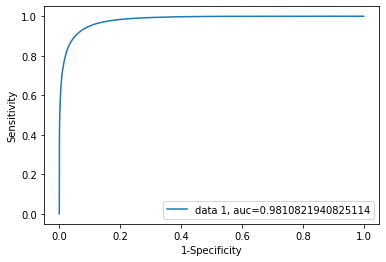

Neural-Nets: PR auc=0.995


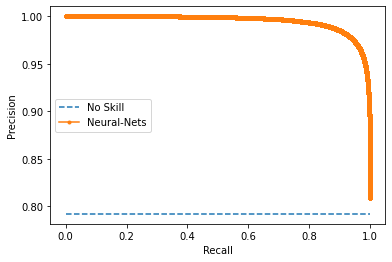

0.9946384518429708

In [368]:
analyze_results(results['target'].values,results['score'].values)

In [387]:
top_bad_reviews =results.sort_values(by =['score'],ascending=False)['review_id'].iloc[0:5]
print(df[df['review_id'].isin(top_bad_reviews)]['review_body'].iloc[0])

Great show! Brilliant dialogue! Excellent acting, superb storyline, wonderful photography !!😊


### Results
1. Model achieved an ROC-AUC of 0.981 on the holdout set below are some reviews classified as good and bad by the model

#### Reviews classified as Good by the model
       1. Great show! Brilliant dialogue! Excellent acting, superb storyline, wonderful photography !!😊
       2. One of the all-time BEST shows ever!  Can't wait for the next episode! Addictive!,
       3. Excellent!  So much fun!  Great movie!!  We LOVED it!!
       4. Fantastic Series! I love it! I'm on Season 4!!!!!!!!!!!!!!!! AAA++++++++++++++++++++++++++++++++++++++=
       5. Excellent. Awesome. Amazing. LOVE THE SHOW!!!!!!!
       
#### Reviews classified as Bad by the model       
     1. Worst movie I have seen in a long time... Horrible acting. Poorly written. Ridiculously cheesy. Lures you in with a promise of supernatural danger that turns out to be the dumbest of the dumb. Don't waste your time.
     2. Not even worth watching for free.  Terrible.  Horrible.  Very Bad.  Should never have been made.  Waste of time.  Crap.  Trash.  Couldn't even finish it.
     3. Why can't I give this no stars? Absolute garbage, stupid, boring, poorly written, bad acting, and terrible direction. I won’t waste another word on this trash. I already lost a couple of hours on my life. Stare at a wall for 2 hours instead of watching this.
     4.Terrible. Poorly written.  Predictable.  Disappointed.
     5.Horrible.  Slow. Boring.  What a disappointment.